In [1]:
import torch
import torch.nn as nn

In [2]:
class Resblock3D(nn.Module):
    def __init__(self,in_ch,out_ch,t_emb_dim):
        super().__init__()

        self.time_mlp = nn.Linear(t_emb_dim,out_ch)

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_ch,out_ch,kernel_size=(1,3,3), padding=(0,1,1)),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(),
            nn.Conv3d(out_ch,out_ch,kernel_size=(3,1,1), padding=(1,0,0))
        )
        self.conv2 = nn.Sequential(
            nn.BatchNorm3d(out_ch),
            nn.ReLU(),
            nn.Conv3d(out_ch,out_ch,kernel_size=(1,3,3), padding=(0,1,1)),
            nn.Conv3d(out_ch,out_ch,kernel_size=(3,1,1), padding=(1,0,0))
        )
        self.reLU=nn.ReLU()
        self.res_conv = nn.Conv3d(in_ch, out_ch,1) if in_ch != out_ch else nn.Identity()

    def forward(self,x,t):
        h= self.conv1(x)
        h+= self.time_mlp(t)[:,:,None,None,None]
        h= self.conv2(h)
        return self.reLU(h+self.res_conv(x))

In [3]:
class tiny3Dunet(nn.Module):
    def __init__(self):
        super().__init__()
        t_dim=256

        self.time_mlp = nn.Sequential(
            nn.Linear(1,t_dim),
            nn.ReLU(),
            nn.Linear(t_dim,t_dim)
        )

        self.inc = nn.Conv3d(2,32,kernel_size=3,padding=1)
        self.down1 = Resblock3D(32,64,t_dim)
        self.pool = nn.MaxPool3d(kernel_size=(1,2,2))
        self.down2 = Resblock3D(64,128,t_dim)

        self.mid = Resblock3D(128,128,t_dim)

        self.up = nn.Upsample(scale_factor=(1,2,2),mode='trilinear',align_corners=False)
        self.up_block1 = Resblock3D(256,64,t_dim)
        self.up_block2 = Resblock3D(128,32,t_dim)

        self.outc = nn.Conv3d(32,1,kernel_size=1)
    def forward(self,x,t):
        t= t.float().view(-1,1)
        t_emb= self.time_mlp(t)

        x0=self.inc(x)
        x1=self.down1(x0,t_emb)
        p1=self.pool(x1)

        x2=self.down2(p1,t_emb)
        p2=self.pool(x2)

        m= self.mid(p2,t_emb)

        u1=self.up(m)
        u1=torch.cat([u1,x2],dim=1)
        u1=self.up_block1(u1,t_emb)

        u2=self.up(u1)
        u2=torch.cat([u2,x1],dim=1)
        u2=self.up_block2(u2,t_emb)

        return self.outc(u2) 

In [17]:
T=1000
beta=torch.linspace(1e-4,0.02,T)
alpha=1-beta
alpha_bar=torch.cumprod(alpha,dim=0)
def q_sample(x0,t,noise=None):
    if noise is None:
        noise=torch.randn_like(x0)
    device=x0.device
    alpha_bar=torch.cumprod(alpha,dim=0).to(device)
    alpha_bart=alpha_bar[t][(...,)+ (None,)*4]
    return torch.sqrt(alpha_bart)*x0+torch.sqrt(1-alpha_bart)*noise

In [5]:
def p_loss_3d(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise=torch.randn_like(x_start)
    
    # Take the first frame as a condition
    condition = x_start[:,:,0,:,:].unsqueeze(2).repeat(1,1,16,1,1)

    # Add noise to the video (Forward)
    x_noisy= q_sample(x_start,t,noise)

    # Concatenate noise and condition to feed it as input
    model_input = torch.cat([x_noisy,condition], dim=1)

    # predicted noise
    predicted_noise = denoise_model(model_input,t)

    # MSE Loss
    return torch.nn.functional.mse_loss(predicted_noise,noise)

In [6]:
model = tiny3Dunet() # Ensure you updated self.inc to 2 channels

# Batch of real videos
real_video = torch.randn(2, 1, 16, 28, 28)
t = torch.randint(0, 1000, (2,))

loss = p_loss_3d(model, real_video, t)
print(f"Loss: {loss.item()}")

Loss: 1.0128729343414307


In [7]:
from scipy.ndimage import distance_transform_edt
from torch.utils.data import Dataset,DataLoader
import numpy as np
from torchvision import datasets, transforms

In [8]:
class MNISTMotionDataset(Dataset):
    def __init__(self,train=True):
        self.mnist_dataset=datasets.MNIST(
            root="./data",
            train=train,
            download=True,
            transform=transforms.ToTensor()
        )
    def __len__(self):
        return len(self.mnist_dataset)
    def simulate_motion(self,image_tensor):
        img_np=image_tensor.squeeze().numpy()
        binary=(img_np>0.5).astype(np.float32)
        dist_map = distance_transform_edt(binary)

        frames = []
        max_dist = dist_map.max()+1e-5

        for i in range(16):
            threshold = (i/16.0)*max_dist*0.8
            frame = (dist_map > threshold).astype(np.float32)
            frames.append(frame)
        video_np = np.array(frames)
        return torch.tensor(video_np).unsqueeze(0)
    def __getitem__(self,idx):
        static_img,label=self.mnist_dataset[idx]
        video = self.simulate_motion(static_img)
        return (video*2)-1,label

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.07MB/s]


Video Shape: torch.Size([1, 16, 28, 28])


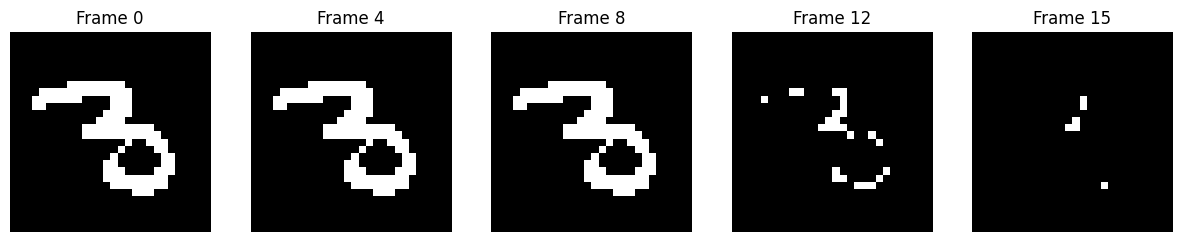

In [9]:
import matplotlib.pyplot as plt

# Init Dataset
ds = MNISTMotionDataset(train=True)
video, label = ds[30] # Get the first video

# It should be shape (1, 16, 28, 28)
print(f"Video Shape: {video.shape}")

# Plot 5 frames to see the "Erosion" effect
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
indices = [0, 4, 8, 12, 15]

for i, idx in enumerate(indices):
    # (Channel, Time, H, W) -> access Time index
    frame = video[0, idx]
    axes[i].imshow(frame, cmap='gray')
    axes[i].set_title(f"Frame {idx}")
    axes[i].axis('off')

plt.show()

In [10]:
import torch.optim as optim
from tqdm import tqdm

In [11]:
# --- 1. Setup ---
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
epochs = 5 # Day 4/5 rapid prototype
batch_size = 16 

# Initialize Components
model = tiny3Dunet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = p_loss_3d # Your custom 3D loss

# Dataset
ds = MNISTMotionDataset(train=True)
train_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

# --- 2. Training Loop ---
print("Starting 3D Training...")
losses = []

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch_video, _ in pbar:
        # batch_video shape: (B, 1, 16, 28, 28)
        batch_video = batch_video.to(device)
        
        # Random Timesteps
        t = torch.randint(0, 1000, (batch_video.shape[0],), device=device).long()
        
        # Calculate Loss
        loss = criterion(model, batch_video, t)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        losses.append(loss.item())
        pbar.set_postfix(MSE=loss.item())

# --- 3. Save the Model ---
torch.save(model.state_dict(), "mnist_motion_3d.pth")
print("Training Complete! Model Saved.")

Starting 3D Training...


Epoch 5/5: 100%|██████████| 3750/3750 [08:18<00:00,  7.53it/s, MSE=0.0515] 

Training Complete! Model Saved.


In [15]:
@torch.no_grad()
def ddpm_reverse_step_3d(model, x, t, condition):
    # Ensure schedules are on the same device as x
    # It is more efficient to move these once outside the loop, 
    # but doing it here ensures it never crashes.
    dev = x.device
    
    # 1. Get constants and move to device
    alpha_t = alpha.to(dev)[t][(...,) + (None,) * 4]
    alpha_bar_t = alpha_bar.to(dev)[t][(...,) + (None,) * 4]
    beta_t = beta.to(dev)[t][(...,) + (None,) * 4]
    
    # 2. Predict noise
    model_input = torch.cat([x, condition], dim=1)
    eps_theta = model(model_input, t)
    
    # 3. Diffusion math
    mean = (1 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta
    )
    
    if t > 0:
        z = torch.randn_like(x)
        return mean + torch.sqrt(beta_t) * z
    else:
        return mean

In [18]:
# Move these to GPU once
alpha = alpha.to(device)
alpha_bar = alpha_bar.to(device)
beta = beta.to(device)

In [19]:
@torch.no_grad()
def sample_motion_video(model, reference_image):
    model.eval()
    # reference_image shape: (1, 28, 28), normalized to [-1, 1]
    
    # 1. Prepare Condition: Repeat Frame 0 for 16 frames
    condition = reference_image.unsqueeze(1).repeat(1, 16, 1, 1).unsqueeze(0).to(device)
    
    # 2. Start with Pure Noise
    samples = torch.randn((1, 1, 16, 28, 28)).to(device)
    
    # 3. Reverse Diffusion Loop
    for i in reversed(range(T)):
        t = torch.tensor([i]).to(device)
        
        # Concatenate Noise + Condition
        model_input = torch.cat([samples, condition], dim=1)
        
        # Predict Noise and Denoise (using your existing DDPM logic)
        # Assuming you have a 3D version of your 'ddpm_reverse_step'
        samples = ddpm_reverse_step_3d(model, samples, t, condition)
        
    return samples

In [20]:
# 1. Pick a random test image
test_ds = MNISTMotionDataset(train=False)
real_video, _ = test_ds[42] # Pick any index
ref_frame = real_video[:, 0, :, :].to(device) # The full digit (Condition)

# 2. Prepare Condition Tensor
# Repeat the static frame 16 times across the time dimension
condition = ref_frame.unsqueeze(1).repeat(1, 16, 1, 1).unsqueeze(0)

# 3. Start from pure noise
cur_x = torch.randn((1, 1, 16, 28, 28)).to(device)

# 4. Loop 1000 steps back to 0
for i in tqdm(reversed(range(T)), total=T, desc="Denoising"):
    t_tensor = torch.tensor([i]).to(device)
    cur_x = ddpm_reverse_step_3d(model, cur_x, t_tensor, condition)

# 5. Final result
# Clamp and rescale to [0, 1]
generated_video = (cur_x.clamp(-1, 1) + 1) / 2
generated_video = generated_video.cpu().squeeze().numpy() # Shape: (16, 28, 28)

Denoising: 100%|██████████| 1000/1000 [00:04<00:00, 223.50it/s]


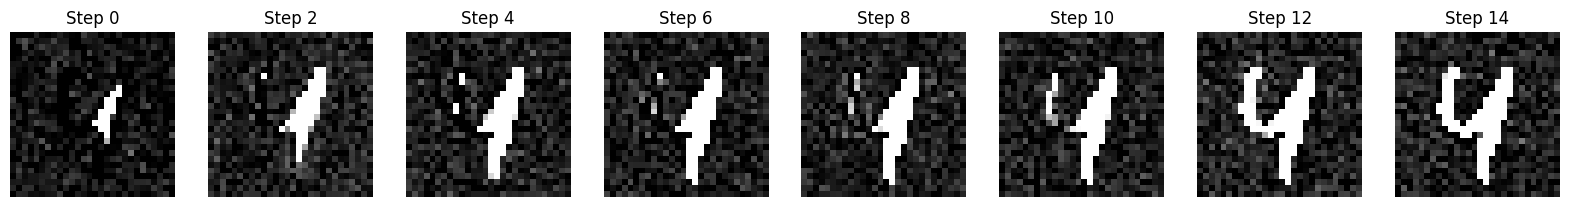

In [21]:
# Note: We play it in REVERSE to show the digit being "drawn"
display_video = generated_video[::-1] 

fig, axes = plt.subplots(1, 8, figsize=(20, 3))
for i in range(8):
    # Show every 2nd frame to see progress
    axes[i].imshow(display_video[i*2], cmap='gray')
    axes[i].set_title(f"Step {i*2}")
    axes[i].axis('off')
plt.show()

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def save_video_as_gif(generated_video, filename="mnist_drawing.gif"):
    # Reverse the video so it goes from "Empty" to "Full"
    # generated_video shape: (16, 28, 28)
    frames_to_show = generated_video[::-1] 

    fig = plt.figure(figsize=(4, 4))
    plt.axis('off')
    
    ims = []
    for i in range(len(frames_to_show)):
        # cmap='gray' for that classic MNIST look
        im = plt.imshow(frames_to_show[i], cmap='gray', animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
    
    # Save as GIF
    ani.save(filename, writer='pillow')
    plt.close()
    print(f"Animation saved as {filename}")

# Usage:
save_video_as_gif(generated_video)

Animation saved as mnist_drawing.gif


In [23]:
def save_comparison_gif(ref_image, generated_video, filename="comparison.gif"):
    # ref_image: (28, 28)
    # generated_video: (16, 28, 28)
    frames_to_show = generated_video[::-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.set_title("Input (Condition)")
    ax2.set_title("Generated Motion")
    
    ims = []
    for i in range(len(frames_to_show)):
        # Static reference on the left
        im1 = ax1.imshow(ref_image, cmap='gray', animated=True)
        # Growing digit on the right
        im2 = ax2.imshow(frames_to_show[i], cmap='gray', animated=True)
        
        ax1.axis('off')
        ax2.axis('off')
        ims.append([im1, im2])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(filename, writer='pillow')
    plt.close()

# Usage (assuming ref_frame is your input image):
save_comparison_gif(ref_frame.cpu().squeeze(), generated_video)

In [24]:
%ls

comparison.gif  data/  mnist_drawing.gif  mnist_motion_3d.pth


Polished animation saved as mnist_polished.gif


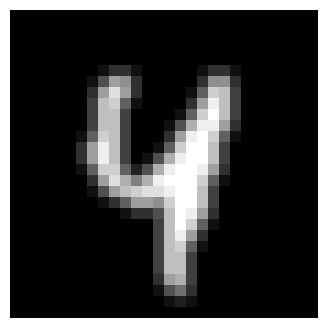

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2 # Using OpenCV for a quick clean-up

def save_polished_gif(generated_video, filename="mnist_polished.gif", threshold=0.4):
    # Reverse and scale to [0, 255]
    frames = (generated_video[::-1] * 255).astype(np.uint8)
    
    fig = plt.figure(figsize=(4, 4))
    plt.axis('off')
    
    ims = []
    for frame in frames:
        # 1. Remove the "Haze" (Anything below threshold becomes black)
        _, clean_frame = cv2.threshold(frame, int(threshold * 255), 255, cv2.THRESH_BINARY)
        
        # 2. Smooth the edges (Optional: makes it look more like liquid ink)
        clean_frame = cv2.GaussianBlur(clean_frame, (3, 3), 0)
        
        im = plt.imshow(clean_frame, cmap='gray', animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(filename, writer='pillow')
    print(f"Polished animation saved as {filename}")

# Usage
save_polished_gif(generated_video, threshold=0.5)